In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Logistic Regress (逻辑回归)
回归模型是预测连续值的模型，例如预测价格，而逻辑回归基于回归模型来处理离散值分类问题的模型，以数字化的格式输入，预测是否为这一类，故其为二分类模型，我们将回归模型令为$\sum_{i}^{n}w_i*x_i$，$w_i$和$x_i$分别代表权重以及输入，逻辑回归基于此，我们令其为sigmoid函数，公式为
$$
h_{w}=\frac{1}{1+e^{\sum_{i}^{n}w_i*x_i}}
$$
sigmoid会被限制在0~1之间，这也是概率的格式，图形如下所示
![](./imgs/sigmoid.png)
为了方便解释，我们假设就只有两个特征，$a$和$b$对应这两个特征的权重，$x$和$y$对应的是特征值，所以我们的回归模型为$\frac{1}{1+e^{ax+by}}$。在优化问题中，有梯度上升以及梯度下降两种方法，梯度上升用于求最大值，梯度下降用于求最小值，我们的逻辑回归代表的是正负样本的概率，可以如下表示
$$
\left\{\begin{matrix}
P(y=1|w,x)=h_w(x)\\ 
P(y=0|w,x)=1-h_w(x)
\end{matrix}\right.
$$
综合写成一个式子可以如下表示
$$
P(y|w,x)=h_w(x)^y(1-h_w(x))^{(1-y)}
$$
我们做的便是最大似然估计法，估计w值，取似然函数為
$$L(w)=\prod P(y|x,w) = \prod h_w(x)^y(1-h_w(x))^{(1-y)}
$$
為了方便取极值，对似然函数取log，形成单调向上的函数
$$l(w)=logL(w) = \sum (y*logh_w(x)+(1-y)*log(1-h_w(x)))$$
最大似然估计就是调优w使得$l(w)$尽可能的大，故需使用梯度上升法求解，为了得到梯度，我们需对此求微分$l'(w)=\sum (h_w(x)-y)*x$  
梯度的更新如下表示
$$
w=w+\alpha \frac {\sum (h_w(x)-y)*x}{m}
$$
$\alpha $代表梯度下降的比例，m代表数据x的长度
### 优缺点

优点：计算量少、容易实现、容易让人理解  
缺点：容易欠拟合、精度低

In [28]:
def loadDataSet():
    dataMat = []; labelMat = []
    fr = open('./datasets/testSet.txt')
    for line in fr.readlines():
        lineArr = line.strip().split()
        dataMat.append([1.0, float(lineArr[0]), float(lineArr[1])])
        labelMat.append(int(lineArr[2]))
    return dataMat,labelMat

def sigmoid(inX):
    return 1.0/(1+np.exp(-inX))

def gradAscent(dataMatIn, classLabels):
    dataMatrix = np.mat(dataMatIn)             #convert to NumPy matrix
    labelMat = np.mat(classLabels).transpose() #convert to NumPy matrix
    m,n = np.shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    weights = np.ones((n,1))
    for k in range(maxCycles):              #heavy on matrix operations
        h = sigmoid(dataMatrix*weights)     #matrix mult
        error = (labelMat - h)              #vector subtraction
        weights = weights + alpha * dataMatrix.transpose()* error # dataMatrix.transpose() represents gradient of weights
    return np.array(weights)
dataArr, labelMat=loadDataSet()
weights=gradAscent(dataArr,labelMat)

[[ 4.12414349]
 [ 0.48007329]
 [-0.6168482 ]]


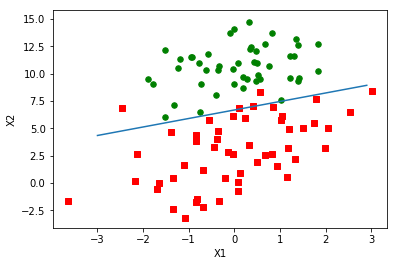

In [31]:
def plotBestFit(weights):
    dataMat,labelMat=loadDataSet()
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0] 
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i])== 1:
            xcord1.append(dataArr[i,1]); ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1]); ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    x = np.arange(-3.0, 3.0, 0.1)
    y = (-weights[0]-weights[1]*x)/weights[2]
    ax.plot(x, y)
    plt.xlabel('X1'); plt.ylabel('X2');
    plt.show()
print(weights)
plotBestFit(weights)

上述的方法在每次训练时都将所有数据一起训练并取梯度，这是不现实的，因为待训练的数据通常都很大，难以载入进内存，故需分批训练，下面我们随机抽取几个数据训练

[14.30003747  0.88605505 -1.98935644]


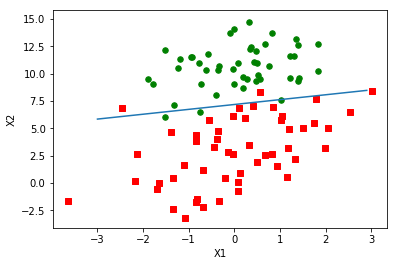

In [36]:
def stocGradAscent1(dataMatrix, classLabels, numIter=150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)   #initialize to all ones
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m):
            alpha = 4/(1.0+j+i)+0.0001    #apha decreases with iteration, does not 
            randIndex = int(np.random.uniform(0,len(dataIndex)))#go to 0 because of the constant
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            del(dataIndex[randIndex])
    return weights
weights=stocGradAscent1(np.array(dataArr),labelMat,500)
print(weights)
plotBestFit(weights)

我们接下来以实际应用-检测马生与死为例，此数据有28个特征，在训练之前，数据有个问题，他有30%的数据是缺失的，我们首先处理缺失值的问题，现今主流的处理缺失值的方法如下：  
- 以均值填补
- 以固定的特殊值填补
- 忽略有缺失的数据
- 利用相似数据的缺失值填补
- 使用其他机器学习算法来预测
由于我们使用numpy读取数据，而numpy不容许缺失值，故我们先以0代表缺失值，0不会影响梯度，且sigmoid(0)=0.5，这也合乎模型预测的概率值

In [38]:
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX*weights))
    if prob > 0.5: return 1.0
    else: return 0.0

def colicTest():
    frTrain = open('datasets/horseColicTraining.txt'); frTest = open('datasets/horseColicTest.txt')
    trainingSet = []; trainingLabels = []
    for line in frTrain.readlines():
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        trainingSet.append(lineArr)
        trainingLabels.append(float(currLine[21]))
    trainWeights = stocGradAscent1(np.array(trainingSet), trainingLabels, 1000)
    errorCount = 0; numTestVec = 0.0
    for line in frTest.readlines():
        numTestVec += 1.0
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        if int(classifyVector(np.array(lineArr), trainWeights))!= int(currLine[21]):
            errorCount += 1
    errorRate = (float(errorCount)/numTestVec)
    print("the error rate of this test is: %f" % errorRate)
    return errorRate

def multiTest():
    numTests = 10; errorSum=0.0
    for k in range(numTests):
        errorSum += colicTest()
    print("after %d iterations the average error rate is: %f" % (numTests, errorSum/float(numTests)))
multiTest()       

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


the error rate of this test is: 0.343284
the error rate of this test is: 0.253731
the error rate of this test is: 0.358209
the error rate of this test is: 0.328358
the error rate of this test is: 0.417910
the error rate of this test is: 0.373134
the error rate of this test is: 0.462687
the error rate of this test is: 0.313433
the error rate of this test is: 0.328358
the error rate of this test is: 0.358209
after 10 iterations the average error rate is: 0.353731
